# **Redes Neurais aplicadas em Séries Temporais**

**Objetivo**: o objetivo desse projeto é desenvolver um modelo preditor que possa realizar o *forecast* do preço do barril de óleo

Fonte dos dados: https://www.kaggle.com/datasets/mabusalah/brent-oil-prices

In [1]:
import warnings
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, \
                            mean_absolute_percentage_error

# ignorar warnings
warnings.filterwarnings('ignore')

In [2]:
# montar o drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# carregar os dados
FILE_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/RedesNeuraisTensorFlow/datasets/BrentOilPrices.csv'
data = pd.read_csv(FILE_PATH, parse_dates=['Date'])
data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [4]:
# análise preliminar
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB


In [5]:
# análise descritiva
data.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [6]:
# mostrar extremos de data
display(data.head(1))
display(data.tail(1))

,Date,Price
0,1987-05-20,18.63


,Date,Price
9010,2022-11-14,93.59


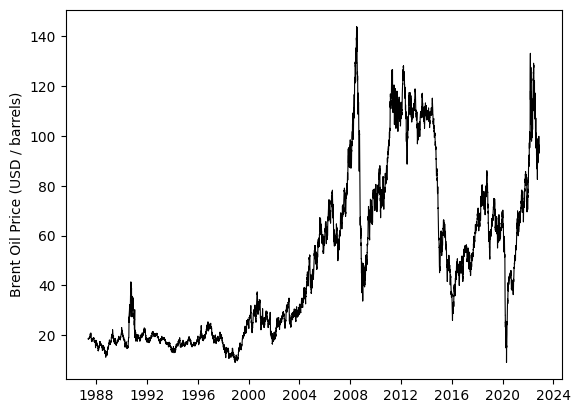

In [7]:
# analisando o comportamento da série temporal
plt.plot(data['Date'], data['Price'], 'k-', lw=0.8)
plt.ylabel('Brent Oil Price (USD / barrels)')
plt.show()

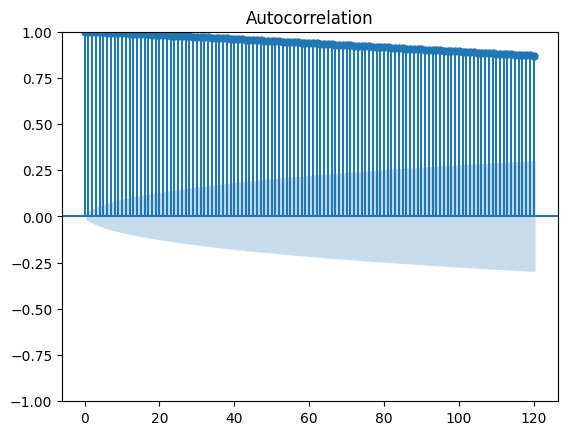

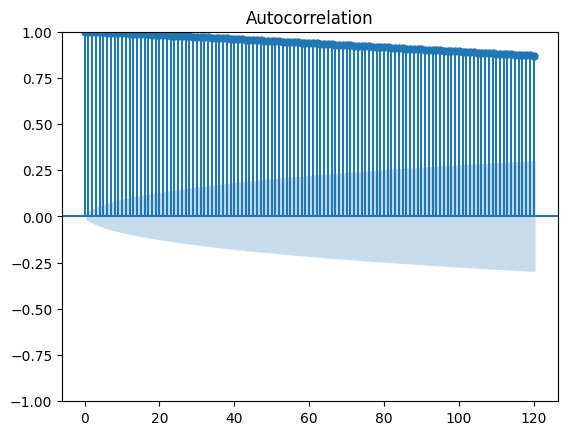

In [8]:
# analisando a autocorrelação
plot_acf(data['Price'], lags=120)

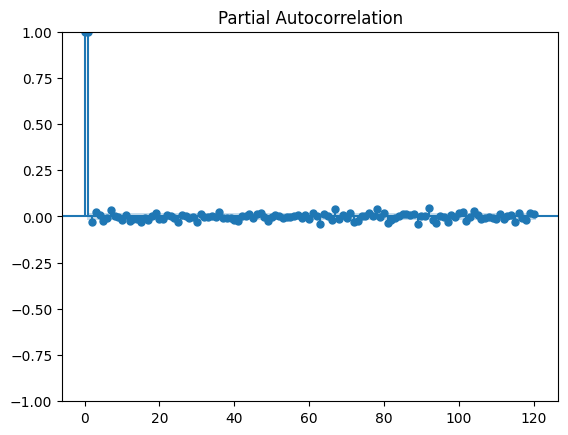

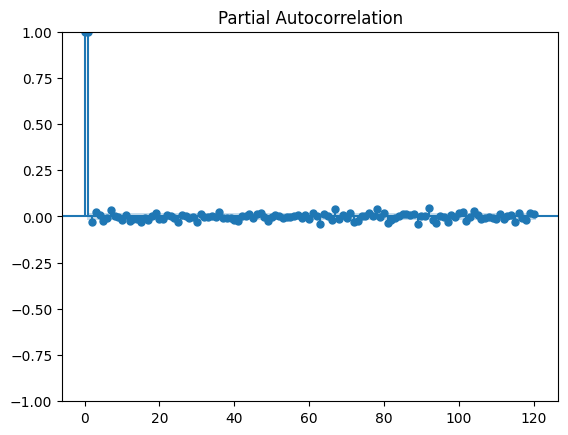

In [9]:
# analisando a autocorrelação parcial
plot_pacf(data['Price'], lags=120)

In [78]:
class PreProcessing:

  def __init__(self) -> None:
    pass

  @staticmethod
  def split_train_val_test(data, split_points: list) -> dict:

    # transformar todos split points em data
    split_points = [pd.to_datetime(d) for d in split_points]

    # obtendo colunas que não sejam data
    cols = [c for c in data.columns if c != 'Date']

    # separar as bases de treino, validação e teste
    train = data.loc[data['Date'] < split_points[1], :]
    test = data.loc[data['Date'] >= split_points[1], cols]
    validation = train.loc[train['Date'] >= split_points[0], cols]
    train = train.loc[train['Date'] < split_points[0], cols]

    return {'train': train, 'val': validation, 'test': test}

  def feature_scaling(self, y: dict) -> dict:

    #  criando o scaler
    self.scaler = MinMaxScaler(feature_range=(0, 1))

    # treinamento do scaler
    self.scaler.fit(y['train'])

    # transformação
    y_norm = {}
    for data in y:
      y_norm[data] = pd.DataFrame(self.scaler.transform(y[data]),
                                  columns=y[data].columns)
    return y_norm

  @staticmethod
  def lag_features(y: dict, n_past: int=1, n_future: int=1) -> dict:

    for data in y:
      for col in y[data].columns:
        y[data][f'{col}_x'] = y[data][col].shift(n_past)
        y[data][f'{col}_y'] = y[data][col].shift(-n_future)

        # eliminação dos dados do presente (supondo que eu não conheça no momento
        # da previsão)
        y[data].drop(columns=[col], inplace=True)

        # tratar os NaNs
        y[data].dropna(inplace=True)

    return y


In [11]:
# testando pré-processamento
pp = PreProcessing()

# definindo split points - momentos importantes
pandemic_start = '2020-01-10'   # começo 'oficial' da COVID-19
end_oil_shock = '2009-01-01'    # fim da crise do oil shock

# separação treino, validação e teste
y = pp.split_train_val_test(data=data, split_points=[end_oil_shock, pandemic_start])

# normalização
y_norm = pp.feature_scaling(y)

# transformando série temporal em aprendizado supervisionado (x -> y)
y_norm = pp.lag_features(y_norm)

In [103]:
class NeuralNetworks:

  # definir constantes
  ACT_HIDDEN = 'relu'
  ACT_OUTPUT = 'tanh'
  OPTIMIZER = 'adam'
  METRICS = ['mean_absolute_error']

  def __init__(self, loss_name) -> None:
    self.LOSS = loss_name

  def create_model(self, x, n_neurons_list) -> None:

    # salvar lista neurons
    self.n_neurons = n_neurons_list

    # definir o modelo sequencial
    self.model = Sequential()

    if len(n_neurons_list) == 1:
      self.model.add(
          Dense(n_neurons_list[0],
                input_shape=(x.shape[1],),
                activation=self.ACT_HIDDEN))
    else:
      for n in n_neurons_list:
        if n == n_neurons_list[0]:
          self.model.add(
              Dense(n,
                    input_shape=(x.shape[1], ),
                    activation=self.ACT_HIDDEN)
          )
        else:
          self.model.add(
              Dense(
                  n,
                  activation=self.ACT_HIDDEN
              )
          )

    # adicionar a camada de saída
    self.model.add(Dense(1, activation=self.ACT_OUTPUT))

  def fit_model(self, x, y, n_epochs, batch_size, x_val, y_val):

    # armazenar entradas como atributos
    self.N_EPOCHS = n_epochs
    self.BATCH_SIZE = batch_size

    # compilar o modelo
    self.model.compile(loss=self.LOSS,
                       optimizer=self.OPTIMIZER,
                       metrics=self.METRICS)

    # treinar o modelo
    self.history = self.model.fit(
        x,
        y,
        epochs=self.N_EPOCHS,
        batch_size=self.BATCH_SIZE,
        validation_data=(x_val, y_val)
    )

  def plot_history(self):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history[self.METRICS[0]], label='Treinamento')
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history[f'val_{self.METRICS[0]}'], label='Validação')
    plt.legend(loc='best')
    plt.xlabel('Número de Épocas')
    plt.ylabel(self.METRICS[0])
    plt.title(f'Curva de Aprendizado - {self.METRICS[0]}')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['loss'], label='Treinamento')
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['val_loss'], label='Validação')
    plt.legend(loc='best')
    plt.xlabel('Número de Épocas')
    plt.ylabel('Função de Perda')
    plt.title('Curva de Aprendizado - Função de Perda')
    plt.show()

  def evaluate_metrics(self, data, scaler) -> pd.Series:

    results = {}

    # obtendo colunas que não sejam preditores
    cols = [c for c in data.columns if c not in ['Price_y', 'VarPrice_y']]

    # realizar previsões
    yhat = self.model.predict(data[cols])

    # voltar y para as grandezas originais
    y_real = scaler.inverse_transform(data[['Price_y']])
    y_pred = scaler.inverse_transform(yhat)

    # calcular as métricas
    r2 = r2_score(y_real, y_pred)
    rmse = mean_squared_error(y_real, y_pred, squared=False)
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)

    results['r2'] = r2
    results['rmse'] = rmse
    results['mae'] = mae
    results['mape'] = mape

    # armazenar hiperparâmetros
    results['n_layers'] = len(self.n_neurons)
    arc = ''
    for i in range(len(self.n_neurons)):
      if i == 0:
        arc += f'{self.n_neurons[i]}'
      elif i == len(self.n_neurons)-1:
        arc += f'-{self.n_neurons[i]}'
      else:
        arc += f'-{self.n_neurons[i]}'
    results['layers'] = arc
    results['epochs'] = self.N_EPOCHS
    results['batch'] = self.BATCH_SIZE
    results['loss'] = self.LOSS

    return pd.Series(results)

  def visualize_predictions(self, data, scaler):

    # realizar previsões
    # obtendo colunas que não sejam data
    cols = [c for c in data.columns if c not in ['Price_y', 'VarPrice_y']]
    yhat = self.model.predict(data[cols])

    # voltar y para as grandezas originais
    y_real = scaler.inverse_transform(data[cols])
    y_pred = scaler.inverse_transform(yhat)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(y_real, 'k-', label='Dados Reais')
    plt.plot(y_pred, 'b--', label='Previsões')
    plt.legend(loc='best')
    plt.xlabel('Amostras')
    plt.ylabel('Oil Price')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(y_real, y_real, 'r-',label='Modelo Ideal')
    plt.plot(y_real, y_pred, 'bo', alpha=0.5, label='Rede Neural')
    plt.legend(loc='best')
    plt.xlabel('Valores Observados')
    plt.ylabel('Valores Preditos')

    plt.show()

In [82]:
# testar a rede neural
loss_list = ['MeanAbsoluteError', 'MeanSquaredError']
nn = NeuralNetworks(loss_list[0])
nn.create_model(x=y_norm['train'][['Price_x']], n_neurons_list=[10])
nn.fit_model(x=y_norm['train'][['Price_x']],
             y=y_norm['train'][['Price_y']],
             n_epochs=50,
             batch_size=64,
             x_val=y_norm['val'][['Price_x']],
             y_val=y_norm['val'][['Price_y']])

Epoch 1/50
86/86 [==============================] - 1s 6ms/step - loss: 0.0939 - mean_absolute_error: 0.0939 - val_loss: 0.3063 - val_mean_absolute_error: 0.3063
Epoch 2/50
86/86 [==============================] - 0s 3ms/step - loss: 0.0585 - mean_absolute_error: 0.0585 - val_loss: 0.1935 - val_mean_absolute_error: 0.1935
Epoch 3/50
86/86 [==============================] - 0s 3ms/step - loss: 0.0291 - mean_absolute_error: 0.0291 - val_loss: 0.0724 - val_mean_absolute_error: 0.0724
Epoch 4/50
86/86 [==============================] - 0s 3ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381
Epoch 5/50
86/86 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369
Epoch 6/50
86/86 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 7/50
86/86 [==========

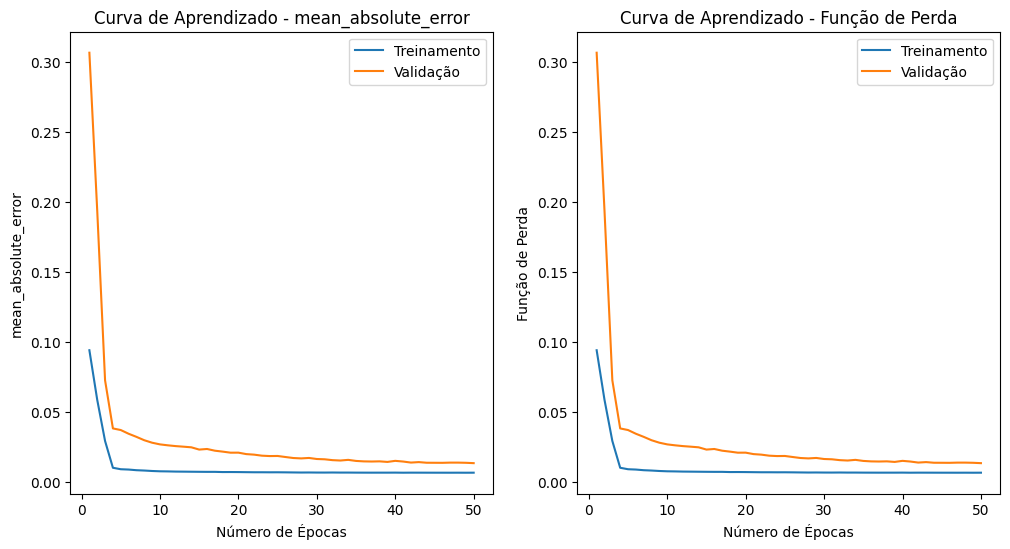

In [83]:
# analisando a curva de aprendizado
nn.plot_history()

In [84]:
# processando a base inteira
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data[['Price']])
val_data = pd.DataFrame(scaler.transform(data[['Price']]), columns=['Price'])
val_data = {'0': val_data}

pp2 = PreProcessing()
val_data = pp2.lag_features(val_data)
val_data = val_data['0']

# analisando métricas
nn.evaluate_metrics(val_data, scaler)

282/282 [==============================] - 0s 1ms/step


r2                   0.996005
rmse                 2.076879
mae                  1.274216
mape                 0.026406
n_layers                    1
layers                     10
epochs                     50
batch                      64
loss        MeanAbsoluteError
dtype: object

282/282 [==============================] - 0s 1ms/step


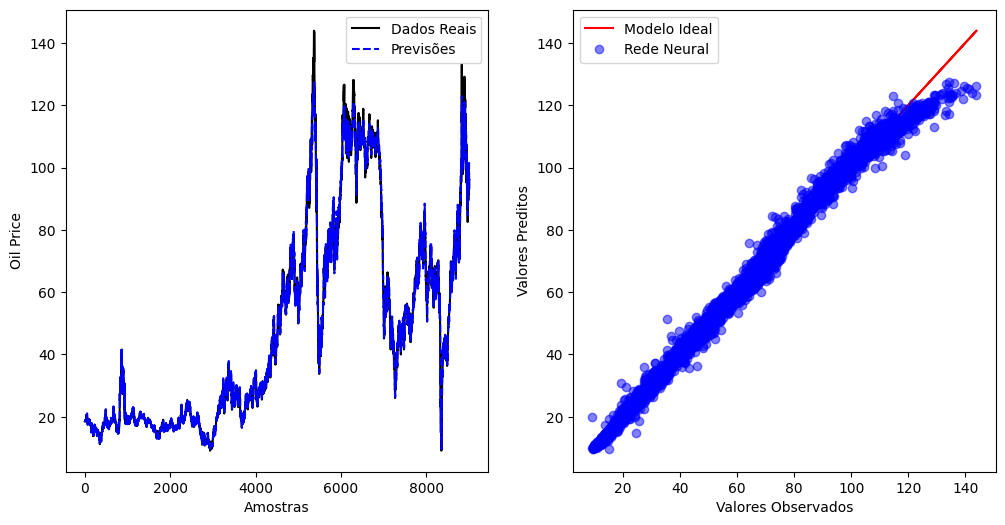

In [85]:
nn.visualize_predictions(val_data, scaler)

In [63]:
# criar um segundo atributo - variação do preço ("derivada")
data2 = data.copy()
data2['VarPrice'] = data['Price'] - data['Price'].shift(1)
data2.head()

,Date,Price,VarPrice
0,1987-05-20,18.63,NaN
1,1987-05-21,18.45,-0.18
2,1987-05-22,18.55,0.10
3,1987-05-25,18.60,0.05
4,1987-05-26,18.63,0.03


<Axes: >

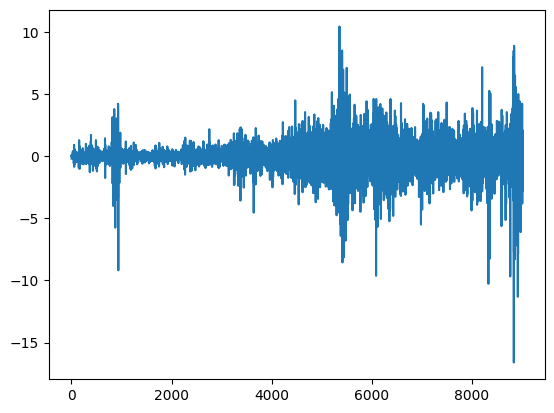

In [64]:
data2['VarPrice'].plot()

In [79]:
# testando pré-processamento
pp2 = PreProcessing()

# definindo split points - momentos importantes
pandemic_start = '2020-01-10'   # começo 'oficial' da COVID-19
end_oil_shock = '2009-01-01'    # fim da crise do oil shock

# separação treino, validação e teste
y = pp2.split_train_val_test(data=data2, split_points=[end_oil_shock, pandemic_start])

# normalização
y_norm = pp2.feature_scaling(y)

# transformando série temporal em aprendizado supervisionado (x -> y)
y_norm = pp2.lag_features(y_norm)

In [81]:
for ds in y_norm:
  y_norm[ds].drop(columns=['VarPrice_y'], inplace=True)

y_norm

{'train':        Price_x   Price_y  VarPrice_x
 2     0.069336  0.070449    0.458482
 3     0.070078  0.070671    0.472746
 4     0.070449  0.070449    0.470199
 5     0.070671  0.070449    0.469180
 6     0.070449  0.070300    0.466123
 ...        ...       ...         ...
 5492  0.225584  0.194067    0.433520
 5493  0.214905  0.187987    0.394294
 5494  0.194067  0.182647    0.324503
 5495  0.187987  0.185836    0.425879
 5496  0.182647  0.193697    0.430973
 
 [5495 rows x 3 columns],
 'val':        Price_x   Price_y  VarPrice_x
 2     0.272451  0.275343    0.615385
 3     0.295069  0.250945    0.623026
 4     0.275343  0.246496    0.332145
 5     0.250945  0.235521    0.300051
 6     0.246496  0.251761    0.437086
 ...        ...       ...         ...
 2783  0.435076  0.429737    0.440652
 2784  0.435076  0.444791    0.467652
 2785  0.429737  0.453467    0.430973
 2786  0.444791  0.442269    0.571065
 2787  0.453467  0.431665    0.527254
 
 [2786 rows x 3 columns],
 'test':       P

In [104]:
nn = NeuralNetworks(loss_list[0])
nn.create_model(x=y_norm['train'][['Price_x', 'VarPrice_x']], n_neurons_list=[10])
nn.fit_model(x=y_norm['train'][['Price_x', 'VarPrice_x']],
             y=y_norm['train'][['Price_y']],
             n_epochs=50,
             batch_size=64,
             x_val=y_norm['val'][['Price_x', 'VarPrice_x']],
             y_val=y_norm['val'][['Price_y']])

Epoch 1/50
86/86 [==============================] - 2s 13ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0877 - val_mean_absolute_error: 0.0877
Epoch 2/50
86/86 [==============================] - 0s 3ms/step - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 3/50
86/86 [==============================] - 0s 4ms/step - loss: 0.0101 - mean_absolute_error: 0.0101 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415
Epoch 4/50
86/86 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 5/50
86/86 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 6/50
86/86 [==============================] - 0s 4ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274
Epoch 7/50
86/86 [=========

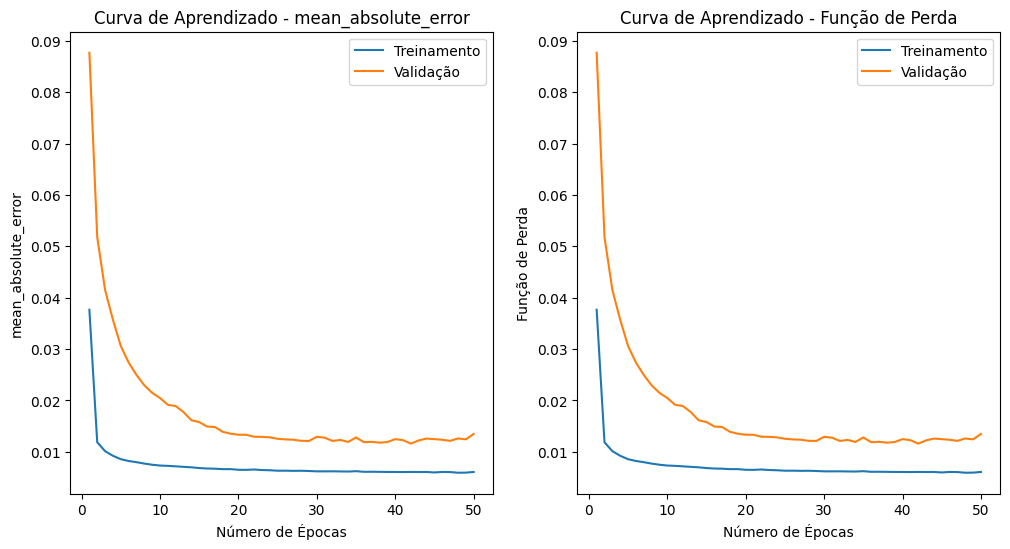

In [105]:
# analisando a curva de aprendizado
nn.plot_history()

In [108]:
# processando a base inteira
scaler = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))

scaler.fit(data2[['Price', 'VarPrice']])
scalerY.fit(data2[['Price']])
val_data = pd.DataFrame(scaler.transform(data2[['Price', 'VarPrice']]), columns=['Price', 'VarPrice'])
val_data = {'0': val_data}

pp2 = PreProcessing()
val_data = pp2.lag_features(val_data)
val_data = val_data['0']

# analisando métricas
nn.evaluate_metrics(val_data, scalerY)

282/282 [==============================] - 1s 2ms/step


r2                   0.996526
rmse                 1.936531
mae                  1.274353
mape                 0.028987
n_layers                    1
layers                     10
epochs                     50
batch                      64
loss        MeanAbsoluteError
dtype: object

282/282 [==============================] - 1s 4ms/step


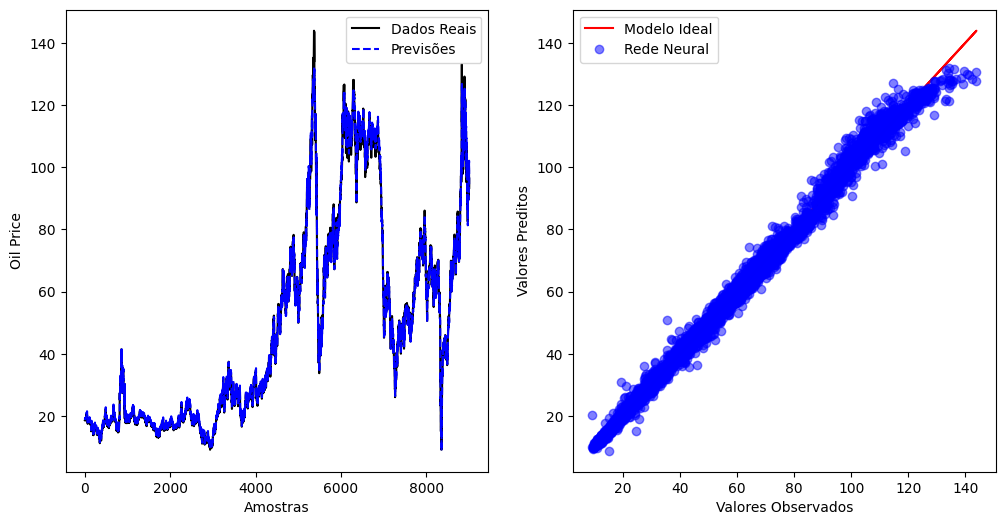

In [109]:
nn.visualize_predictions(val_data, scalerY)